## 0. 데이터 수집

In [6]:
'''
# 크롤링 코드 (예시로 5페이지까지만 추출)

import csv, time, random, re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By 
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# 아이디, 비밀번호
USR = "아이디"  
PWD = "비밀번호" 

COMPANY_REVIEWS_BASE = "https://www.jobplanet.co.kr/companies/58863/reviews/%EC%9D%B4%EC%8A%A4%ED%8A%B8%EC%86%8C%ED%94%84%ED%8A%B8?page={}"  
START_PAGE = 1       
END_PAGE = 5         
OUTPUT_CSV = "jobplanet_rivew_sample.csv" 

## 함수 정의

# 크롬 드라이버
def new_driver():
    opts = Options()
    service = Service(r"C:\cd\chromedriver-win64\chromedriver.exe") 
    driver = webdriver.Chrome(service=service, options=opts)
    driver.set_page_load_timeout(60)
    driver.implicitly_wait(3)
    return driver

# 잡플래닛 로그인
def login_jobplanet(driver, usr, pwd):
    driver.get("https://www.jobplanet.co.kr/users/sign_in?_nav=gb")
    wait = WebDriverWait(driver, 20)

    email = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "input#user_email")))
    pw = driver.find_element(By.CSS_SELECTOR, "input#user_password")

    email.clear(); email.send_keys(usr)
    pw.clear(); pw.send_keys(pwd)
    pw.send_keys(Keys.RETURN)

    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "body")))
    time.sleep(2)

# 제목 / 장점 / 단점 / 경영진 의견 추출
def parse_review_cards_from_html(html):
    soup = BeautifulSoup(html, "html.parser")
    results = []

    containers = []
    sel_candidates = [
        'article[class*="review"]', 'section[class*="review"]',
        'div[class*="review"]', 'li[class*="review"]',
        'article[class*="card"]',  'section[class*="card"]',
        'div[class*="card"]',      'li[class*="card"]',
        'article[class*="item"]',  'div[class*="item"]'
    ]
    for sel in sel_candidates:
        containers.extend(soup.select(sel))
    containers = list(dict.fromkeys(containers))
    if not containers:
        containers = soup.select("article, section, li, div")

    LABELS = ("장점", "단점", "경영진에게 바라는 점", "바라는 점")
    SPLIT_NEXT = ("장점", "단점", "경영진에게 바라는 점", "바라는 점", "총평", "복지", "연봉", "업무", "문화")

    # 공백/광고 문구 제거
    def clean(txt: str) -> str:
        if not txt:
            return ""
        txt = re.sub(r"\s+", " ", txt).strip()
        txt = re.sub(r"(잡플래닛|추천|혜택|광고).*$", "", txt)
        return txt.strip()

    # 라벨 분리
    def extract_by_labels(block):
        text = block.get_text("\n", strip = True)

        hit_count = sum(1 for lb in LABELS if lb in text)
        if hit_count < 2:
            return None

        title = ""
        for sel in ["a.tit", "h3", "h2", "h4", "div.title", "p.tit", "a"]:
            el = block.select_one(sel)
            if el and el.get_text(strip=True):
                title = clean(el.get_text(strip=True))
                if len(title) < 120:
                    break

        # 라벨별 텍스트 추출
        def grab_after(label, raw):
            if label not in raw:
                return ""
            part = raw.split(label, 1)[1]
            # 다음 라벨이 나오면 그 전까지만 자르기
            cut_idx = len(part)
            for nxt in SPLIT_NEXT:
                if nxt == label:
                    continue
                idx = part.find(nxt)
                if idx != -1:
                    cut_idx = min(cut_idx, idx)
            return clean(part[:cut_idx])

        pros = grab_after("장점", text) or grab_after("장 점", text)
        cons = grab_after("단점", text) or grab_after("단 점", text)
        advice = grab_after("경영진에게 바라는 점", text) or grab_after("바라는 점", text)

        if not (pros or cons or advice):
            return None

        return {
            "제목": title,
            "장점": pros,
            "단점": cons,
            "경영진에게 하고싶은 말": advice
        }

    for block in containers:
        item = extract_by_labels(block)
        if item:
            results.append(item)

    dedup = []
    seen = set()
    for r in results:
        key = (r.get("제목", ""), r.get("장점", "")[:40], r.get("단점", "")[:40], r.get("경영진에게 하고싶은 말", "")[:40])
        if key in seen:
            continue
        seen.add(key)
        if not (r.get("장점") or r.get("단점") or r.get("경영진에게 하고싶은 말")):
            continue
        dedup.append(r)

    return dedup

# 크롤링 함수
def crawl_company_reviews(base_url, start_page, end_page):
    driver = new_driver()
    wait = WebDriverWait(driver, 20)
    rows = []

    try:
        login_jobplanet(driver, USR, PWD)

        for page in range(start_page, end_page + 1):
            url = base_url.format(page)
            driver.get(url)
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "body")))
            time.sleep(random.uniform(2.0, 3.5))

            items = parse_review_cards_from_html(driver.page_source)
            rows.extend(items)
            print("[{}] 수집 {}건 (누적 {})".format(page, len(items), len(rows)))

            try:
                close_btn = driver.find_element(By.CSS_SELECTOR, "button.btn_close_x_ty1, button[class*='close']")
                close_btn.click()
                time.sleep(0.5)
            except Exception:
                pass

            time.sleep(random.uniform(1.0, 2.0))

    finally:
        driver.quit()

    # 불필요한 문장 및 빈 리뷰 제거
    cleaned_rows = []
    for r in rows:
        adv = r.get("경영진에게 하고싶은 말", "")
        if adv:
            r["경영진에게 하고싶은 말"] = re.sub(r"1\s*년\s*후[\s\S]*", "", adv, flags=re.MULTILINE).strip()

        cons = r.get("단점", "")
        if cons:
            r["단점"] = re.sub(r"경영진에[\s\S]*", "", cons, flags=re.MULTILINE).strip()

        if all(r.get(k, "").strip() for k in ["제목", "장점", "단점", "경영진에게 하고싶은 말"]):
            cleaned_rows.append(r)

    # CSV 파일 저장
    fieldnames = ["제목", "장점", "단점", "경영진에게 하고싶은 말"]
    with open(OUTPUT_CSV, "w", newline="", encoding="utf-8-sig") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        for r in cleaned_rows:
            w.writerow({k: r.get(k, "") for k in fieldnames})

    print("{}에 총 {}건 저장".format(OUTPUT_CSV, len(cleaned_rows)))


# 실행 
if __name__ == "__main__":
    crawl_company_reviews(COMPANY_REVIEWS_BASE, START_PAGE, END_PAGE)
'''

[1] 수집 5건 (누적 5)
[2] 수집 5건 (누적 10)
[3] 수집 4건 (누적 14)
[4] 수집 5건 (누적 19)
[5] 수집 5건 (누적 24)
jobplanet_rivew_sample.csv에 총 23건 저장


## 1. 데이터 전처리 ##

In [2]:
# 데이터셋 불러오기 (1) - 깃허브

import pandas as pd

url = url = "https://raw.githubusercontent.com/Kim-JeongCheol/JP_Review_Text_Mining_and_Search_Model/main/data/jobplanet_rivew.csv"
df = pd.read_csv(url)
df.head(5)

,제목,장점,단점,경영진에게 하고싶은 말
0,고인물들의 세계가 깨지고 있다. 새로운 변화중,"높은 브랜드 인지도, 자유로운 휴가, 워라밸을 지지하는 문화 등","비전없음, 경영진 능력 부족, 뭘 해야할지 잘 모름, 이것저것 간만 봄",뭘 해야할지 모르겠으면 공부하세요. 비전있는 경영진이 필요합니다.
1,기업문화가 좋습니다. 되게 자유롭고 일에 몰두할 수 있었어요,재택 근무가 가장 큰 장점입니다. 1층에 카페도 저렴해서 좋았습니다.,재택근무가 아니라면 단점이 될 수도 있는 점이 꽤 많을것 같습니다,AI도 좋지만 다른 서비스도 신경써주세요
2,네임밸류 있고 나름 좋은 기업으로 기억함,회사나 제품이 네임밸류가 좀 있다보니 일하는데 있어서 자부심 비슷한게 있음,인력 관리가 잘 안되는 듯. 그래서 단기간 근무하고 이직하는 직원들이 많음,핵심 인력들의 장기근속을 위한 조치를 마련해주세요.
3,신입들은 들어와서 회사가 이런곳이구나 알고 가면 좋은 회사,그나마 재택근무 있어서 회사에 계속 다녔다. 이거마저 없어지면 남아서 다닐 사람은 ...,"잘 되지도않고 다른 회사랑 차별점도 없는 AI 뜬구름만 보고 쫓아감, 수직적인",딱히 바라는건 없고 그냥 하던대로 하세요
4,자유롭고 자율적이네 실적이 필요하다.,재택근무 3일의 장점이 크다 아주 큰 장점 복지도 꽤나 좋다,자율이란 이름의 방치 혹은 압박 존재 개발자만 그럴수도..,"연구,개발보단 기획,마케팅이 우선되는 느낌입니다"


In [ ]:
'''
# 데이터셋 불러오기 (2) - 로컬

import pandas as pd

df = pd.read_csv("./data/jobplanet_rivew.csv")
df.head(5)
'''

In [9]:
# 데이터셋 기본 구조

print("데이터 크기 : {}".format(df.shape))
print("컬럼명 : {}".format(df.columns.tolist()))

데이터 크기 : (367, 4)
컬럼명 : ['제목', '장점', '단점', '경영진에게 하고싶은 말']


In [10]:
# 결측치 확인

df.isna().sum()

제목              0
장점              0
단점              0
경영진에게 하고싶은 말    2
dtype: int64

In [11]:
# 결측치 위치 확인

df[df['경영진에게 하고싶은 말'].isna()]

,제목,장점,단점,경영진에게 하고싶은 말
336,여자가 다니기 괜찮은 회사,부서마다 차이가 있겠지만 남녀 차별이 없다. 술 권하지 않는다. 출산 휴가가 자유롭...,"어딜가나 있겠지만, 뒷담화 하는 사람이 있음. 부서마다 차이 있겠지만 끼리끼리 어울...",NaN
365,이스트소프트,"회사 문화와 사람들의 충성도, 그리고 매니지먼트의 도덕성 장점인 회사","너무 커지다 보니, 창조성이 점점 떨어지고 있음",NaN


In [12]:
# 결측치 공백으로 메우기

df = df.fillna("")
print(df.isna().sum()) 

제목              0
장점              0
단점              0
경영진에게 하고싶은 말    0
dtype: int64


In [13]:
# 결과 확인

df.loc[[336, 365]]

,제목,장점,단점,경영진에게 하고싶은 말
336,여자가 다니기 괜찮은 회사,부서마다 차이가 있겠지만 남녀 차별이 없다. 술 권하지 않는다. 출산 휴가가 자유롭...,"어딜가나 있겠지만, 뒷담화 하는 사람이 있음. 부서마다 차이 있겠지만 끼리끼리 어울...",
365,이스트소프트,"회사 문화와 사람들의 충성도, 그리고 매니지먼트의 도덕성 장점인 회사","너무 커지다 보니, 창조성이 점점 떨어지고 있음",


## 2. EDA ##

2 - 1. 단어 빈도 분석

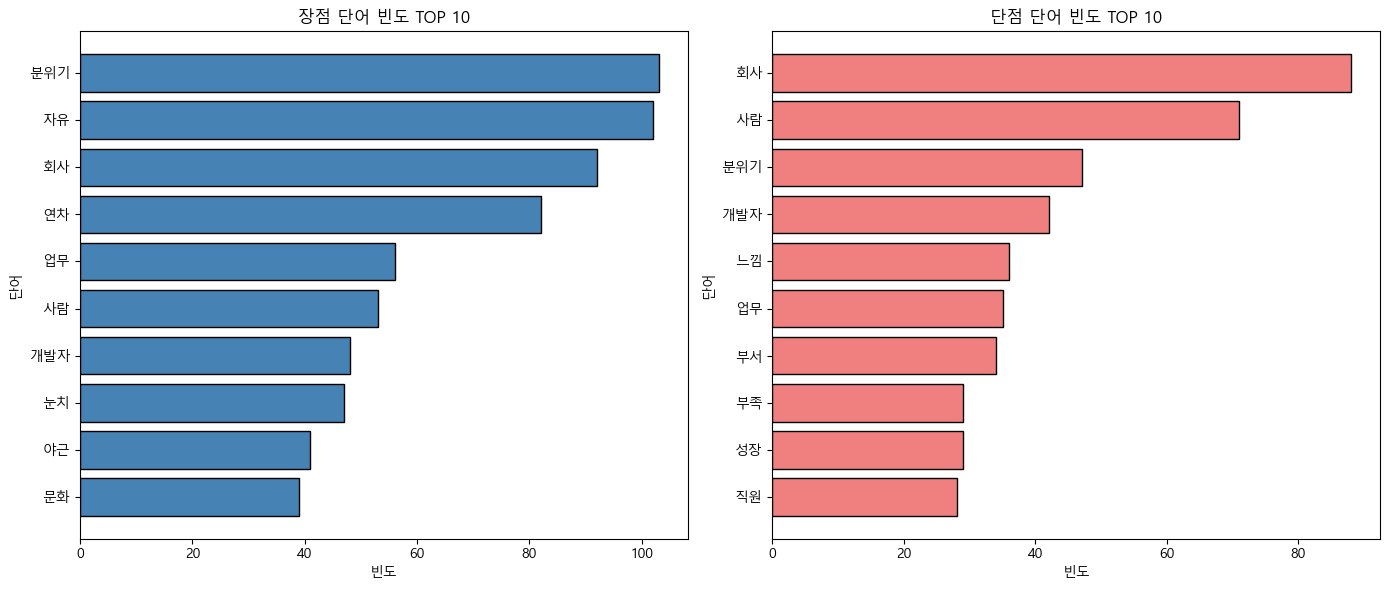

In [14]:
from kiwipiepy import Kiwi
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family = 'Malgun Gothic')
kiwi = Kiwi()

# 토큰화 함수
def tokenize(text):
    tokens = []
    for token in kiwi.tokenize(text, normalize_coda = True):
        if token.tag in ["NNG", "NNP", "VA"]:  # NNG = 일반명사, NNP = 고유명사, VA = 형용사
            if len(token.form) > 1:  
                tokens.append(token.form)
    return tokens

# 장점
pos_text = " ".join(df['장점'].astype(str))
pos_tokens = tokenize(pos_text)
pos_counter = Counter(pos_tokens)
pos_df = pd.DataFrame(pos_counter.items(), columns=["단어","빈도"])
pos_top = pos_df.sort_values("빈도", ascending = True).tail(10) 

# 단점
neg_text = " ".join(df['단점'].astype(str))
neg_tokens = tokenize(neg_text)
neg_counter = Counter(neg_tokens)
neg_df = pd.DataFrame(neg_counter.items(), columns=["단어","빈도"])
neg_top = neg_df.sort_values("빈도", ascending = True).tail(10)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].barh(pos_top["단어"], pos_top["빈도"], color = "steelblue", edgecolor = "black")
axes[0].set_title("장점 단어 빈도 TOP 10")
axes[0].set_xlabel("빈도")
axes[0].set_ylabel("단어")

axes[1].barh(neg_top["단어"], neg_top["빈도"], color = "lightcoral", edgecolor = "black")
axes[1].set_title("단점 단어 빈도 TOP 10")
axes[1].set_xlabel("빈도")
axes[1].set_ylabel("단어")

plt.tight_layout()
plt.show()

In [15]:
## 표 시각화

# 데이터 준비
pos_keywords = ["분위기", "자유", "연차", "업무", "눈치", "야근", "문화"]
neg_keywords = ["사람", "느낌", "부서", "성장", "부족", "직원"]
mix_keywords = ["회사", "개발자"]  

# 행 수 맞추기 
max_len = max(len(pos_keywords), len(neg_keywords), len(mix_keywords))
pad = lambda lst: lst + [""] * (max_len - len(lst))

df2 = pd.DataFrame({
    "장점 키워드": pad(pos_keywords),
    "단점 키워드": pad(neg_keywords),
    "복합적 키워드": pad(mix_keywords),
})

# 스타일 지정 함수
def colorize(val, col):
    if val == "":
        return ""
    if col == "장점 키워드":
        return "color: steelblue; font-weight: bold;"
    elif col == "단점 키워드":
        return "color: lightcoral; font-weight: bold;"
    elif col == "복합적 키워드":
        return "color: mediumpurple; font-weight: bold;"
    return ""

# 스타일 적용 
styled_df = (
    df2.style
    .apply(lambda s: [colorize(v, s.name) for v in s], axis = 0)
    .hide_index()
)

# 시각화
styled_df

C:\Users\김정철\AppData\Local\Temp\ipykernel_960\1635766958.py:34: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index()


장점 키워드,단점 키워드,복합적 키워드
분위기,사람,회사
자유,느낌,개발자
연차,부서,
업무,성장,
눈치,부족,
야근,직원,
문화,,


2 - 2. 워드클라우드 생성

In [16]:
from wordcloud import WordCloud
from collections import Counter

# 토큰화 함수 
def tokenize(text):
    tokens = []
    for token in kiwi.tokenize(text, normalize_coda = True):
        if token.tag in ["NNG", "NNP", "VA"]:  # 일반명사, 고유명사, 형용사
            if len(token.form) > 1:  
                tokens.append(token.form)
    return tokens

# 워드클라우드 함수
def make_wordcloud(text, title, font_path = "C:/Windows/Fonts/malgun.ttf"):
    tokens = tokenize(text)
    counter = Counter(tokens)
    wordcloud = WordCloud(
        font_path = font_path,
        background_color = "white",
        width = 800,
        height = 600
    ).generate_from_frequencies(counter)

    plt.figure(figsize = (8,6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(title, fontsize = 18)
    plt.show()

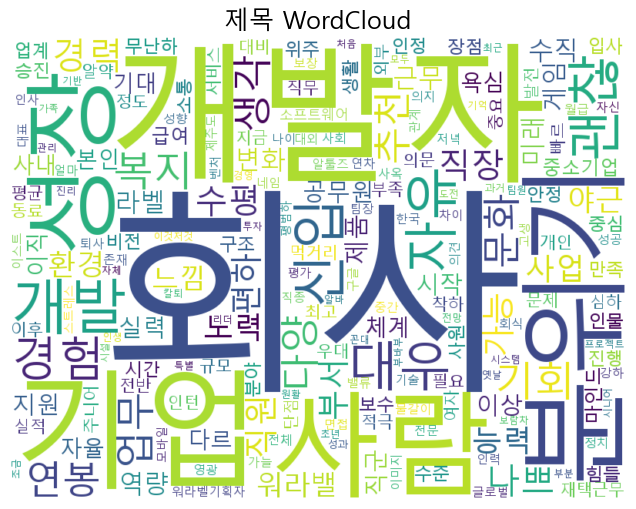

In [17]:
make_wordcloud(" ".join(df['제목'].astype(str)), "제목 WordCloud")

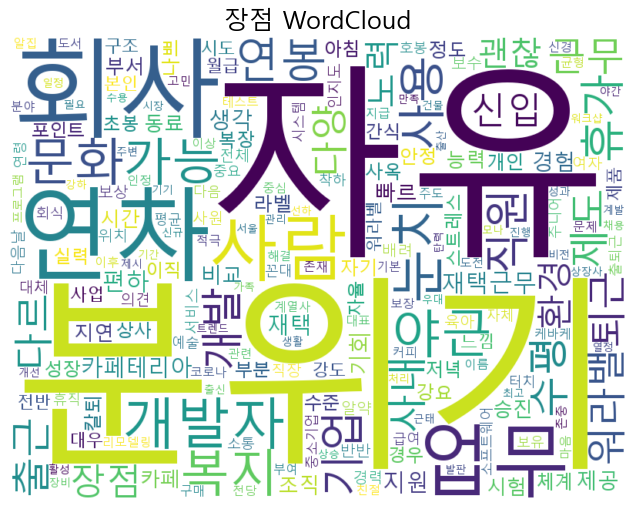

In [18]:
make_wordcloud(" ".join(df['장점'].astype(str)), "장점 WordCloud")

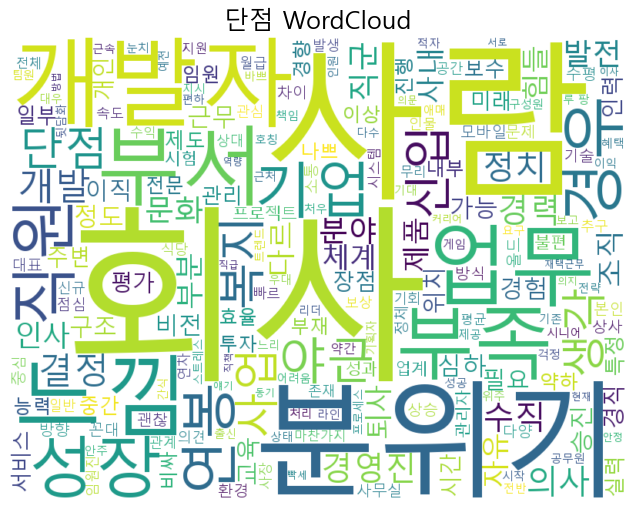

In [19]:
make_wordcloud(" ".join(df['단점'].astype(str)), "단점 WordCloud")

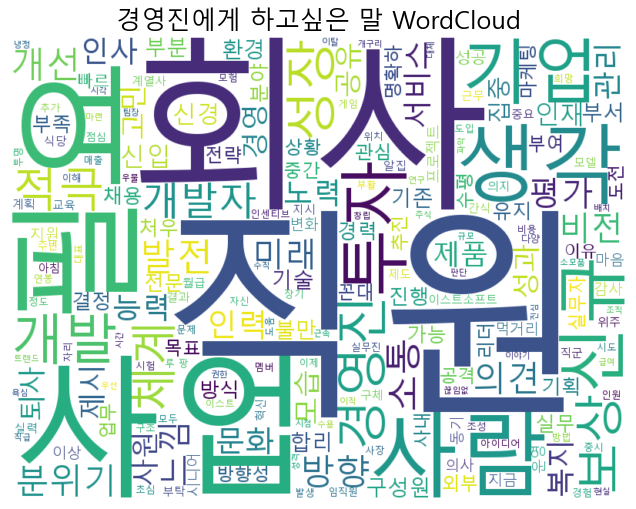

In [20]:
make_wordcloud(" ".join(df['경영진에게 하고싶은 말'].astype(str)), "경영진에게 하고싶은 말 WordCloud")

2 - 3. tf idf 장단점 비교

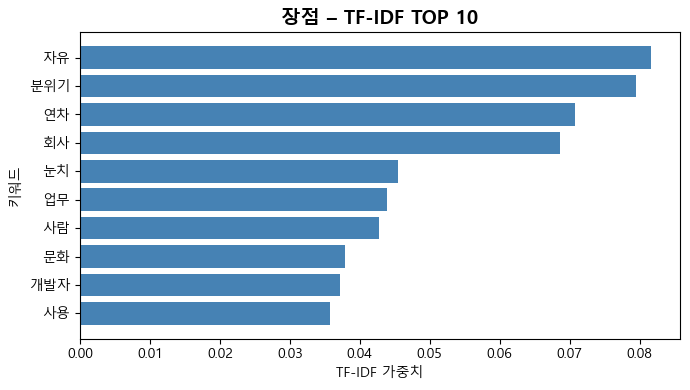

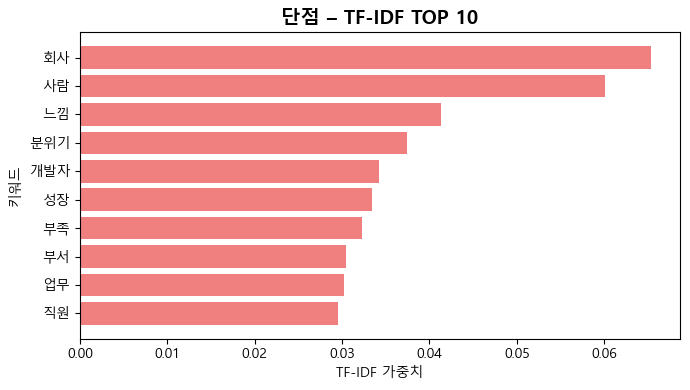

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  장점 및 단점 라벨
docs = df['장점'].astype(str).tolist() + df['단점'].astype(str).tolist()
labels = ["장점"]*len(df) + ["단점"]*len(df)

# TF-IDF 벡터화 
vectorizer = TfidfVectorizer(
    tokenizer = tokenize,
    token_pattern = None,   
    max_features = 200,
    lowercase = False
)

X = vectorizer.fit_transform(docs)

# 데이터프레임 변환
tfidf_scores = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
tfidf_scores['label'] = labels

# 시각화 함수
def plot_top_tfidf(tfidf_scores, category, topn=10, font = 'Malgun Gothic'):
    subset = (tfidf_scores[tfidf_scores['label'] == category]
              .mean(numeric_only = True)
              .sort_values(ascending = False)
              .head(topn))
    
    plt.rcParams['font.family'] = font
    plt.figure(figsize = (7,4))
    
    color = "steelblue" if category == "장점" else "lightcoral"
    
    plt.barh(subset.index[::-1], subset.values[::-1], color=color)
    plt.title("{} – TF-IDF TOP {}".format(category, topn), fontsize=14, fontweight="bold")
    plt.xlabel("TF-IDF 가중치")
    plt.ylabel("키워드")
    plt.tight_layout()
    plt.show()

# 시각화
for c in ["장점", "단점"]:
    plot_top_tfidf(tfidf_scores, c, topn=10)

In [22]:
## 표 시각화

# 리스트(원하는 순서로 넣으면 됨)
pos = ["자유", "분위기", "연차", "눈치", "업무", "문화", "야근"]
neg = ["사람", "느낌", "성장", "부족", "부서", "직원"]
mix = ["회사", "개발자"]

# 공백 설정
max_len = max(len(pos), len(neg), len(mix))
pad = lambda L: L + [""] * (max_len - len(L))
pos, neg, mix = pad(pos), pad(neg), pad(mix)

# 데이터프레임 생성
df_tbl = pd.DataFrame({
    "장점 키워드": pos,
    "단점 키워드": neg,
    "복합적 키워드": mix,
})

#  스타일 지정 함수
def style_table(df):
    s = (df.style
            .set_properties(**{"text-align": "center", "font-size": "14px", "font-weight": "bold"})
            .hide(axis="index")
            .set_table_styles([
                {"selector": "th", "props": [("text-align", "center"), ("font-weight", "bold"), ("font-size", "15px")]}
            ])
            .set_properties(subset = ["장점 키워드"], **{"color": "#1f77b4"})
            .set_properties(subset = ["단점 키워드"], **{"color": "#e37777"})
            .set_properties(subset = ["복합적 키워드"], **{"color": "#7e57c2"})
        )
    return s

# 시각화
style_table(df_tbl)

장점 키워드,단점 키워드,복합적 키워드
자유,사람,회사
분위기,느낌,개발자
연차,성장,
눈치,부족,
업무,부서,
문화,직원,
야근,,


## 3. 가설 검증

3-1. 이스트소프트 기업은 장점보다 단점이 많은 회사인가?

단점 문장의 길이가 장점 문장의 길이보다 길면 단점이 장점보다 많은 회사라고 간주

* Welch’s t-검정 사용

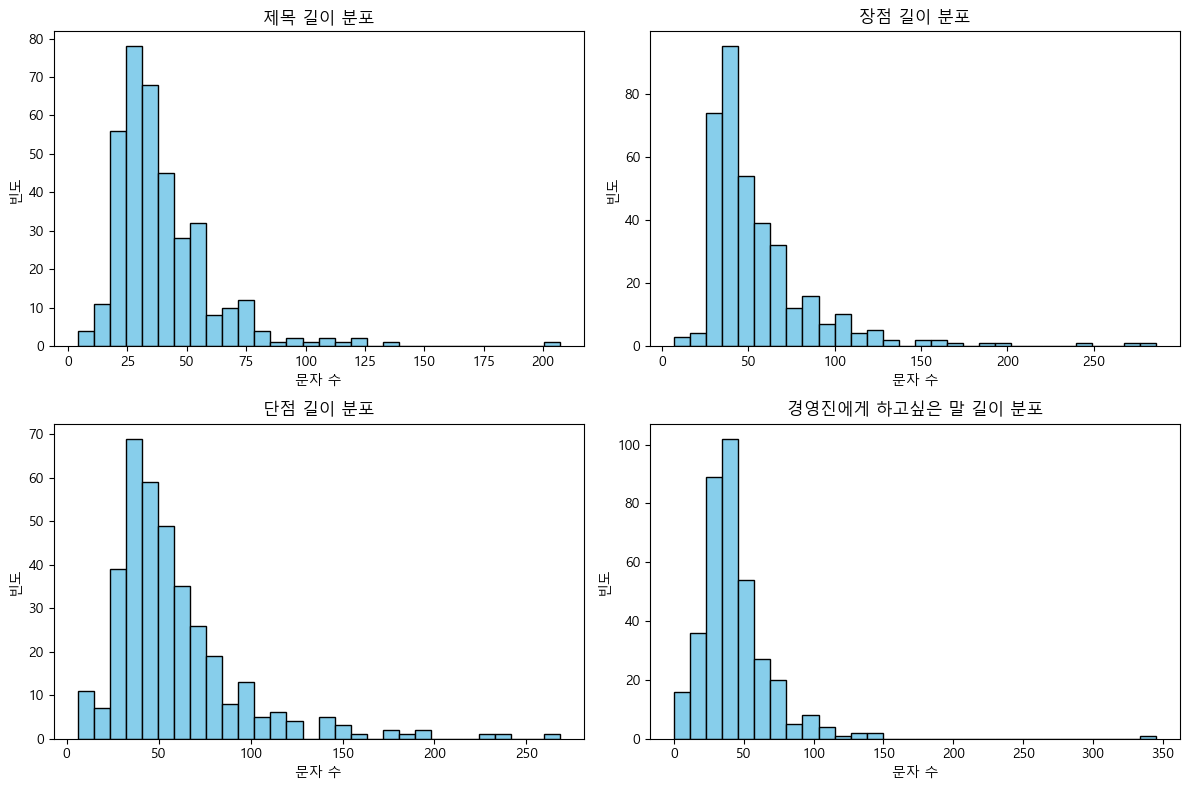

In [23]:
## 전체적인 분포 시각화

# 한글 폰트 설정 (맑은 고딕)
rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 각 컬럼별 텍스트 길이 계산
length = df.astype(str).apply(lambda x : x.str.len())

# 2 * 2 subplot 생성
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
axes = axes.flatten() 

# 각 컬럼별 히스토그램 생성
for i, col in enumerate(length.columns):
    axes[i].hist(length[col], bins = 30, color = "skyblue", edgecolor = "black")
    axes[i].set_title("{} 길이 분포".format(col))
    axes[i].set_xlabel("문자 수")
    axes[i].set_ylabel("빈도")

# 시각화
plt.tight_layout()
plt.show()

In [24]:
# 각 컬럼별 텍스트 길이 통계

stat = length.describe().round(2)
stat

,제목,장점,단점,경영진에게 하고싶은 말
count,367.00,367.00,367.00,367.00
mean,39.55,55.93,58.44,43.55
std,21.42,33.82,35.69,27.45
min,4.00,7.00,6.00,0.00
25%,26.00,35.00,36.00,28.00
50%,34.00,46.00,49.00,39.00
75%,47.00,64.00,69.00,51.00
max,207.00,286.00,268.00,345.00


In [25]:
## Welch’s t-검정 

import numpy as np
from scipy.stats import ttest_ind

# 각 문장 길이 계산
pros = df['장점'].astype(str).str.len()
cons = df['단점'].astype(str).str.len()

# 가설 검정
t_stat, p_value = ttest_ind(cons, pros, equal_var=False, alternative='greater')

# 결과 출력
print("\nT 통계량: {:.3f}".format(t_stat))
print("p-value: {:.3f}".format(p_value))

alpha = 0.05  # 유의수준

# 판단
if p_value < alpha:
    print("이스트소프트 기업은 장점보다 단점이 많은 회사일 것이다.")
else:
    print("이스트소프트 기업은 장점보다 단점이 많은 회사라고 보긴 어렵다.")


T 통계량: 0.979
p-value: 0.164
이스트소프트 기업은 장점보다 단점이 많은 회사라고 보긴 어렵다.


3 - 2. 신입 교육이 지원자 감소의 원인 중 하나이다.

* 대응표본 t-검정 사용

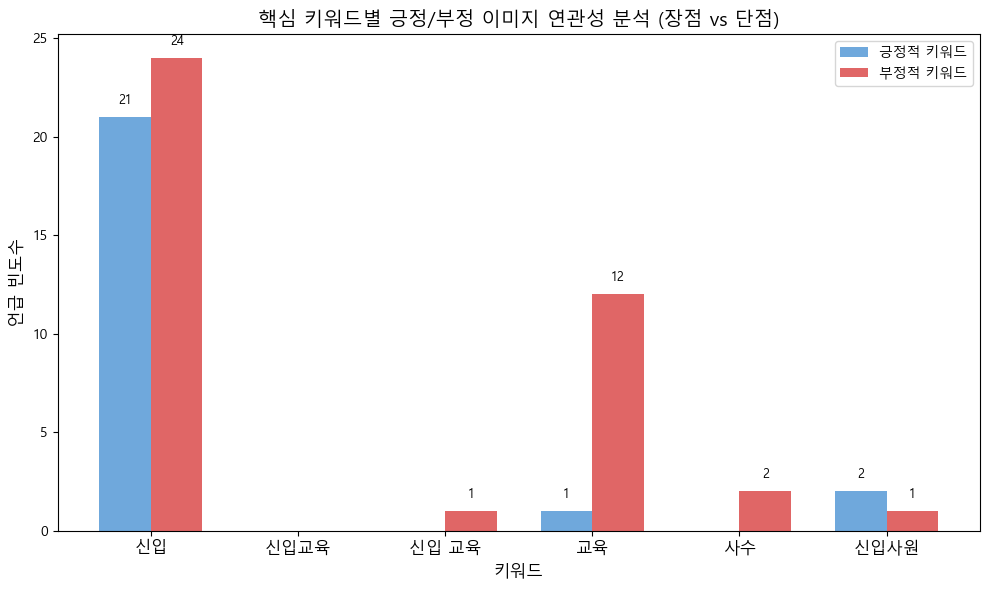

In [26]:
import re

def clean_text(text):
    if pd.isna(text): return ""
    return re.sub('[^가-힣\s]', '', str(text))

target_keywords_sentiment = ['신입', '신입교육', '신입 교육', '교육', '사수', '신입사원']

sentiment_columns = {
    '장점': '긍정적 이미지',
    '단점': '부정적 이미지'
}
sentiment_df = pd.DataFrame(0, index=target_keywords_sentiment, columns=sentiment_columns.values())

for col_name, sentiment_label in sentiment_columns.items():
    cleaned_column = df[col_name].apply(clean_text)

    for keyword in target_keywords_sentiment:
        count = cleaned_column.str.count(keyword).sum()
        sentiment_df.loc[keyword, sentiment_label] = count

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(target_keywords_sentiment))

bars1 = ax.bar([i - bar_width/2 for i in index], sentiment_df['긍정적 이미지'], bar_width, label='긍정적 키워드', color='#6FA8DC')
bars2 = ax.bar([i + bar_width/2 for i in index], sentiment_df['부정적 이미지'], bar_width, label='부정적 키워드', color='#E06666')

plt.title('핵심 키워드별 긍정/부정 이미지 연관성 분석 (장점 vs 단점)', fontsize=14)
plt.ylabel('언급 빈도수', fontsize=12)
plt.xlabel('키워드', fontsize=12)

plt.xticks(index, target_keywords_sentiment, fontsize=12) 
plt.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
                    '%d' % int(height), ha='center', va='bottom', fontsize=9)
autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

In [27]:
## 대응표본 t-검정 

import scipy.stats as stats

positive_counts = sentiment_df['긍정적 이미지']
negative_counts = sentiment_df['부정적 이미지']

t_statistic, p_value = stats.ttest_rel(positive_counts, negative_counts)
alpha = 0.05


if p_value < alpha:
    result = "귀무가설 기각 (유의미한 차이 있음)"
else:
    result = "귀무가설 기각 실패 (유의미한 차이 없음)"


test_results_data = [
    ('분석 방법', 'Paired T-test'),
    ('가설', '평균 언급 빈도에 차이가 없다 (귀무가설)'),
    ('T-statistic', f'{t_statistic:.4f}'),
    ('P-value', f'{p_value:.4f}'),
    ('유의 수준 (α)', f'{alpha}'),
    ('결론', result)
]

test_results_df = pd.DataFrame(test_results_data, columns=['지표', '값'])

print("\n" + "=" * 50)
print(" " * 10 + "핵심 키워드 긍정/부정 빈도 가설 검정 결과")
print("=" * 50)

print(test_results_df.to_string(index=False, header=False))
print("=" * 50)


          핵심 키워드 긍정/부정 빈도 가설 검정 결과
      분석 방법           Paired T-test
         가설 평균 언급 빈도에 차이가 없다 (귀무가설)
T-statistic                 -1.5119
    P-value                  0.1910
  유의 수준 (α)                    0.05
         결론 귀무가설 기각 실패 (유의미한 차이 없음)


3 - 3. 개발 부서 일이 다른 부서 일보다 더 고될것이다.

In [28]:
# 코드 파일 따로 제출

3-4. 우수 인재 유출의 가장 큰 원인은 성장 가능성의 부재일 것이다.

* 카이제곱 검정 사용

In [29]:
# 이직 사유 유형별 키워드 정의
attrition_keywords = {
    "경쟁력 없는 연봉": ['연봉', '월급', '급여', '보상', '인상률', '상승률', '인센티브', '성과급'],
    "성장 기회 없음": ['성장', '커리어', '발전', '배울점', '기회', '승진', '진급', '고인물', '정체'],
    "관리자의 문제": ['관리자', '팀장', '리더', '꼰대', '수직적', '정치', '불통', '편애', '감정적', '탑다운'],
    "업무의 의미 인식 부족": ['비전', '방향성', '목표', '의미', '보람', '뜬구름', '목적의식', '동기부여'],
    "기대가 없거나 불분명함": ['온보딩', '신입', '교육', '체계', '시스템', '목표', '가이드', '방치', '인수인계'],
    "번아웃": ['번아웃', '야근', '업무량', '과도', '혹사', '압박', '스트레스', '휴식', '소진'],
    "IT에 대한 최상층 지원 부족": ['경영진', '리더십', '의사결정', '지원', '투자', '구시대적'],
    "최첨단 기술/기회 없음": ['기술', '신기술', '트렌드', '레거시', '코드', '개발문화', '도전'],
    "정기적인 상태 확인 없음": ['피드백', '면담', '원온원', '1on1', '관심', '소통 부재'],
    "교류 부족": ['교류', '소통', '협업', '팀워크', '사회 활동', '동료', '어울리기', '파벌'],
    "불충분한 유연성": ['유연', '재택', '원격', '자율', '출퇴근', '워라밸', '마이크로매니징', '통제'],
    "직장 내 외로움": ['외로움', '소속감', '개인주의', '삭막', '차가운', '겉도는', '비인간적']
}

# '단점' 컬럼 분석 및 카운트
if not df.empty:
    # NaN 값을 안전하게 처리하기 위해 빈 문자열로 변경
    df['단점'] = df['단점'].fillna('')

    # 각 유형별 카운트를 저장할 딕셔너리 초기화
    type_counts = {key: 0 for key in attrition_keywords.keys()}

    # '단점' 컬럼의 각 리뷰를 순회하며 키워드 카운트
    for review in df['단점']:
        # 한 리뷰에서 같은 유형이 여러 번 카운트되는 것을 방지하기 위해 set 사용
        found_types_in_review = set()
        for attr_type, keywords in attrition_keywords.items():
            for keyword in keywords:
                if keyword in review:
                    found_types_in_review.add(attr_type)

        # 찾은 유형들의 카운트를 1씩 증가
        for found_type in found_types_in_review:
            type_counts[found_type] += 1

    # 결과 출력
    # 결과를 보기 쉽게 데이터프레임으로 변환
    result_df = pd.DataFrame(list(type_counts.items()), columns=['이직 사유 유형', '언급된 리뷰 수'])

    # 언급된 리뷰 수가 많은 순으로 정렬
    sorted_result_df = result_df.sort_values(by='언급된 리뷰 수', ascending=False).reset_index(drop=True)

    print("\n--- '단점' 리뷰 키워드 분석 결과 ---")
    print(sorted_result_df)


--- '단점' 리뷰 키워드 분석 결과 ---
            이직 사유 유형  언급된 리뷰 수
0           성장 기회 없음        70
1            관리자의 문제        52
2       기대가 없거나 불분명함        41
3   IT에 대한 최상층 지원 부족        38
4          경쟁력 없는 연봉        35
5                번아웃        23
6       업무의 의미 인식 부족        19
7       최첨단 기술/기회 없음        16
8              교류 부족        11
9           불충분한 유연성        10
10     정기적인 상태 확인 없음         7
11          직장 내 외로움         2


In [30]:
## 카이제곱 검정

from scipy.stats import chisquare

observed_frequencies = np.array([70, 52, 41, 38, 35, 23, 19, 16, 11, 10, 7, 2])
chi2_statistic, p_value = chisquare(observed_frequencies)

print("--- 12개 이직 사유 유형 간 빈도 차이 검증 (카이제곱 적합도 검정) ---")
print(f"관측된 빈도: {observed_frequencies}")
print(f"총합: {np.sum(observed_frequencies)}")
print(f"기대 빈도 (각 유형별): {np.sum(observed_frequencies) / len(observed_frequencies)}")
print("-" * 50)
print(f"카이제곱 통계량 (Chi-squared Statistic): {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print("-" * 50)

# 4. 결과 해석
alpha = 0.05
print(f"유의수준(alpha): {alpha}")

if p_value < alpha:
    print("결론: P-value가 유의수준보다 작으므로, 귀무가설을 기각합니다.")
    print("-> 12가지 이직 사유 유형별 언급 빈도에는 통계적으로 유의미한 차이가 있습니다.")
    print("-> 즉, 특정 이직 사유가 다른 사유에 비해 더 많이 또는 적게 언급되는 경향이 있으며, 이는 우연이라고 보기 어렵습니다.")
else:
    print("결론: P-value가 유의수준보다 크므로, 귀무가설을 기각할 수 없습니다.")
    print("-> 12가지 이직 사유 유형별 언급 빈도 차이가 통계적으로 유의미하다고 말할 수 없습니다.")

--- 12개 이직 사유 유형 간 빈도 차이 검증 (카이제곱 적합도 검정) ---
관측된 빈도: [70 52 41 38 35 23 19 16 11 10  7  2]
총합: 324
기대 빈도 (각 유형별): 27.0
--------------------------------------------------
카이제곱 통계량 (Chi-squared Statistic): 171.3333
P-value: 0.0000
--------------------------------------------------
유의수준(alpha): 0.05
결론: P-value가 유의수준보다 작으므로, 귀무가설을 기각합니다.
-> 12가지 이직 사유 유형별 언급 빈도에는 통계적으로 유의미한 차이가 있습니다.
-> 즉, 특정 이직 사유가 다른 사유에 비해 더 많이 또는 적게 언급되는 경향이 있으며, 이는 우연이라고 보기 어렵습니다.


3 - 5. 운영진에게 하고싶은 말은 부정이 긍정보다 많을 것이다.

* 이항 검정 사용

In [31]:
import os, zipfile, io, requests

# KNU 감성사전 
ZIP_URL = "https://github.com/park1200656/KnuSentiLex/archive/refs/heads/master.zip"
DEST_DIR = "./KnuSentiLex-master"

if not os.path.exists(DEST_DIR):
    resp = requests.get(ZIP_URL)
    resp.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(resp.content)) as zf:
        zf.extractall(".")

POS_PATH = os.path.join(DEST_DIR, "pos_pol_word.txt")
NEG_PATH = os.path.join(DEST_DIR, "neg_pol_word.txt")

# 긍정/부정 단어
def load_list(path):
    with open(path, "r", encoding = "utf-8") as f:
        return [line.strip() for line in f if line.strip()]

pos_words = load_list(POS_PATH)
neg_words = load_list(NEG_PATH)

# 간단 점수 함수
def lexicon_score(text: str) -> int:
    score = 0
    for w in pos_words:
        if w in text:
            score += 1
    for w in neg_words:
        if w in text:
            score -= 1
    return score

def lexicon_label(text: str) -> str:
    s = lexicon_score(str(text))
    if s > 0:
        return "긍정"
    elif s < 0:
        return "부정"
    else:
        return "중립"

# 데이터프레임에 새로운 컬럼 생성
df["경영진_감성_KNU"] = df["경영진에게 하고싶은 말"].astype(str).apply(lexicon_label)

# 결과 출력
print(df["경영진_감성_KNU"].value_counts())

중립    139
긍정    136
부정     92
Name: 경영진_감성_KNU, dtype: int64


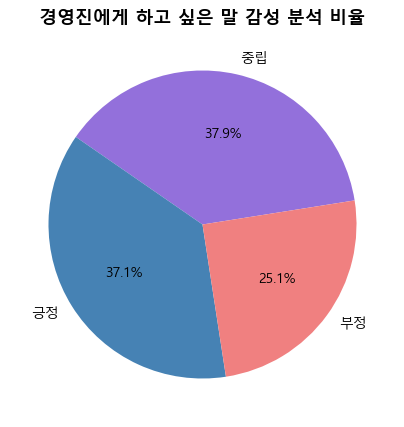

In [32]:
## 파이 차트로 시각화

# 분포 집계
counts = df["경영진_감성_KNU"].value_counts()

# 2) 색상 설정
color_map = {
    "긍정": "steelblue",
    "부정": "lightcoral",
    "중립": "mediumpurple"  # 긍정+부정 중간 느낌 색상
}

colors = [color_map[label] for label in counts.index]

# 시각화
plt.figure(figsize = (5,5))
plt.pie(counts.values, labels = counts.index, autopct = "%.1f%%", 
        colors = colors, startangle = 9)
plt.title("경영진에게 하고 싶은 말 감성 분석 비율", fontsize = 13, weight = "bold")
plt.show()

In [33]:
## 이항 검정

from scipy.stats import binomtest

# 긍정 부정만 추출
sent = df[df["경영진_감성_KNU"].isin(["긍정", "부정"])]

n_neg = (sent["경영진_감성_KNU"] == "부정").sum()
n_pos = (sent["경영진_감성_KNU"] == "긍정").sum()
n_total = n_neg + n_pos

print("부정:", n_neg, "긍정:", n_pos, "총:", n_total)

# 가설 검정
res = binomtest(n_neg, n_total, p = 0.5, alternative = 'greater')
print("p-value: {:.4f}".format(res.pvalue))

alpha = 0.05 # 유의수준
if res.pvalue < alpha:
    print("직원들은 운영진에게 칭찬보다 쓴소리를 더 많이 남긴다.")
else:
    print("직원들이 운영진에게 칭찬보다 쓴소리를 더 많이 남긴다고 보기는 어렵다.")

부정: 92 긍정: 136 총: 228
p-value: 0.9986
직원들이 운영진에게 칭찬보다 쓴소리를 더 많이 남긴다고 보기는 어렵다.


## 4. 모델링

In [34]:
from sklearn.neighbors import NearestNeighbors

# 텍스트 통합
df["text"] = (df["제목"] + " ").str.repeat(2) + df["장점"] + " " + df["단점"] + " " + df["경영진에게 하고싶은 말"]

# 공개 한국어 불용어 리스트 불러오기 (stopwords-iso)
STOP = set(requests.get(
    "https://raw.githubusercontent.com/stopwords-iso/stopwords-ko/master/stopwords-ko.txt"
).text.split('\n'))

# 토크나이저 재정의
def kiwi_tokenizer(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r"[^\w\s가-힣]", " ", text) 
    toks = []
    for t in kiwi.tokenize(text, normalize_coda=True):
        tag = t.tag
        if tag.startswith("N") or tag in ("VV","VA","XR","SL"):
            w = t.form.lower().strip()
            if len(w) > 1 and w not in STOP:
                toks.append(w)
    return toks

# 하이퍼파라미터 (아래 코드 참조)
CFG = {
    "tfidf": {
        "tokenizer": kiwi_tokenizer,
        "ngram_range": (1, 1),
        "min_df": 10,
        "max_df": 0.8,
        "max_features": 40_000,
        "sublinear_tf": True,
        "norm": "l2",
        "use_idf": True
    },
    "knn": {
        "metric": "cosine",
        "algorithm": "brute",
        "n_neighbors": 50,
        "n_jobs": -1
    }
}

# TF-IDF 벡터화 및 KNN 인덱스 구축
tfidf = TfidfVectorizer(**CFG["tfidf"])
X = tfidf.fit_transform(df["text"])
nbrs = NearestNeighbors(**CFG["knn"]).fit(X)

C:\anaconda3\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
'''
## 하이퍼 파라미터 튜닝
import itertools

# 데이터 수정
df["text"] = (df["제목"] + " ").str.repeat(2) \
             + df["장점"] + " " \
             + df["단점"] + " " \
             + df["경영진에게 하고싶은 말"]

# 평가 함수
def mean_similarity(tfidf, nbrs, keywords, k=10):
    sims = []
    for kw in keywords:
        qv = tfidf.transform([kw])
        dist, _ = nbrs.kneighbors(qv, n_neighbors=k)
        sims.extend([1 - float(d) for d in dist[0]])
    return float(np.mean(sims)) if sims else 0.0

# 하이퍼파라미터 
GRID = {
    "ngram_range": [(1,1), (1,2), (2,2), (1,3)],
    "min_df": [2, 3, 5, 10],
    "max_df": [0.80, 0.85, 0.90, 0.95],
    "max_features": [40_000, 80_000, 120_000, 160_000]
}

EVAL_KEYWORDS = ["야근","복지","연봉","소통","승진","평가"]
NEIGHBORS, K_EVAL = 50, 10

combos = list(itertools.product(GRID["ngram_range"], GRID["min_df"], GRID["max_df"], GRID["max_features"]))

# 탐색
rows = []
best = {"score": -1, "tfidf": None, "nbrs": None, "cfg": None}

for (ngram, mdf, mxf, mfeat) in combos:
    tfidf = TfidfVectorizer(
        tokenizer = kiwi_tokenizer, token_pattern = None,
        ngram_range = ngram, min_df = mdf, max_df = mxf, max_features = mfeat,
        sublinear_tf = True, norm = "l2", use_idf = True
    )
    X = tfidf.fit_transform(df["text"])
    nbrs = NearestNeighbors(metric = "cosine", algorithm = "brute",
                            n_neighbors = NEIGHBORS, n_jobs = -1).fit(X)
    score = mean_similarity(tfidf, nbrs, EVAL_KEYWORDS, k = K_EVAL)

    rows.append({
        "ngram_range": ngram,
        "min_df": mdf,
        "max_df": mxf,
        "max_features": mfeat,
        "vocab_size": X.shape[1],
        "mean_sim": round(score, 6)
    })

    if score > best["score"]:
        best.update({"score": score, "tfidf": tfidf, "nbrs": nbrs, "cfg": (ngram, mdf, mxf, mfeat)})

# 결과 출력
res_df = pd.DataFrame(rows).sort_values("mean_sim", ascending = False).reset_index(drop = True)
res_df.insert(0, "rank", res_df.index + 1)

print(res_df.head(5).to_string(index = False))
print("[Best] ngram_range = {0}, min_df = {1}, max_df = {2}, max_features = {3} → mean_sim={4:.4f}".format(
    best["cfg"][0], best["cfg"][1], best["cfg"][2], best["cfg"][3], best["score"]
))
'''

'\n## 하이퍼 파라미터 튜닝\nimport itertools\n\n# 데이터 수정\ndf["text"] = (df["제목"] + " ").str.repeat(2)              + df["장점"] + " "              + df["단점"] + " "              + df["경영진에게 하고싶은 말"]\n\n# 평가 함수\ndef mean_similarity(tfidf, nbrs, keywords, k=10):\n    sims = []\n    for kw in keywords:\n        qv = tfidf.transform([kw])\n        dist, _ = nbrs.kneighbors(qv, n_neighbors=k)\n        sims.extend([1 - float(d) for d in dist[0]])\n    return float(np.mean(sims)) if sims else 0.0\n\n# 하이퍼파라미터 \nGRID = {\n    "ngram_range": [(1,1), (1,2), (2,2), (1,3)],\n    "min_df": [2, 3, 5, 10],\n    "max_df": [0.80, 0.85, 0.90, 0.95],\n    "max_features": [40_000, 80_000, 120_000, 160_000]\n}\n\nEVAL_KEYWORDS = ["야근","복지","연봉","소통","승진","평가"]\nNEIGHBORS, K_EVAL = 50, 10\n\ncombos = list(itertools.product(GRID["ngram_range"], GRID["min_df"], GRID["max_df"], GRID["max_features"]))\n\n# 탐색\nrows = []\nbest = {"score": -1, "tfidf": None, "nbrs": None, "cfg": None}\n\nfor (ngram, mdf, mxf, mfeat) in combo

In [36]:
## 활용 예시 ("야근" 키워드와 가장 연관된 문장 상위 10개)

from IPython.display import display, HTML

# 베스트 모델 입력
tfidf_best = tfidf
nbrs_best  = nbrs

# 검색 함수
def search(query, k=10):
    k_req = min(max(int(k), 50), len(df))

    qv = tfidf_best.transform([query])
    dist, idx = nbrs_best.kneighbors(qv, n_neighbors=k_req)
    qtok = set(kiwi_tokenizer(query))

    def _snippet(text, qtokens, maxlen=140, context=70):
        if not isinstance(text, str) or not text:
            return ""
        found_span = None
        for qt in sorted(qtokens, key=len, reverse=True):
            m = re.search(re.escape(qt), text, flags=re.IGNORECASE)
            if m:
                s = max(0, m.start() - context)
                e = min(len(text), m.end() + context)
                found_span = (s, e)
                break
        if found_span:
            s, e = found_span
            snip = text[s:e]
            if s > 0: snip = "..." + snip
            if e < len(text): snip = snip + "..."
        else:
            snip = text[:maxlen] + ("..." if len(text) > maxlen else "")
        for qt in sorted(qtokens, key = len, reverse = True):
            snip = re.sub(re.escape(qt), lambda m: "[[{}]]".format(m.group(0)), snip, flags=re.IGNORECASE)
        return snip

    rows = []

    for rank, (d, i) in enumerate(zip(dist[0][:k], idx[0][:k]), start=1):
        sim = 1 - float(d)
        r = df.iloc[int(i)]
        content = "\n".join([
            "제목- {}".format(_snippet(r.get("제목", ""), qtok, 80, 40)),
            "장점- {}".format(_snippet(r.get("장점", ""), qtok, 140, 70)),
            "단점- {}".format(_snippet(r.get("단점", ""), qtok, 140, 70)),
            "경영진에게 하고싶은 말- {}".format(_snippet(r.get("경영진에게 하고싶은 말", ""), qtok, 140, 70))
        ])
        rows.append({"순위": rank, "유사도": round(sim, 4), "내용": content})
    return pd.DataFrame(rows)

# 표 시각화 함수
def display_search_result(df_result):
    dfv = df_result.copy()
    dfv["유사도"] = dfv["유사도"].map(lambda x: f"{float(x):.3f}")

    dfv["내용"] = dfv["내용"].str.replace("\n", "<br>")

    styler = dfv.style

    try:
        styler = styler.hide(axis="index")
    except Exception:
        styler = styler.hide_index()

    styler = (
        styler
        .set_properties(subset=["순위"],  **{"text-align":"center", "width":"56px"})
        .set_properties(subset=["유사도"], **{"text-align":"center", "width":"76px"})
        .set_properties(subset=["내용"],  **{
            "text-align":"left",
            "white-space":"normal",
            "word-break":"break-all",
            "line-height":"1.6",
            "padding":"10px 12px"
        })
        .set_table_styles([
            {"selector":"table", "props":"border-collapse:collapse; table-layout:fixed; width:100%; font-size:13px;"},
            {"selector":"th",    "props":"background:#f5f5f7; text-align:center; font-weight:600; border:1px solid #d9d9d9; padding:8px;"},
            {"selector":"td",    "props":"border:1px solid #d9d9d9; vertical-align:top; padding:8px;"},
            {"selector":"tbody td:nth-child(1), tbody td:nth-child(2)", "props":"text-align:center;"},
        ])
    )

    display(HTML(styler.to_html(escape = False)))

# 예시 실행 
res = search("야근", k = 10)
display_search_result(res)

순위,유사도,내용
1,0.406,제목- 개발자 실력들이 좋다. 같이 커갈 수 있는 곳장점- 사람들이 좋다. 서실 이게 제일 중요하다고 본다. 동료가 좋아야 일할 맛도 나니까단점- 좀 일이 많다. 요샌 어떤지 모르겠는데 예전엔 [[야근]][[야근]]의 연속이었다.경영진에게 하고싶은 말- 글쎄 딱히 바라는건 없고 일을 좀 줄였으면 한다.
2,0.348,제목- 어느 개발사가 그렇듯 개발자가 갑인 회사 정치알력싸움이 상당한 회사장점- [[야근]]하면 다음날 지연출근 제도가 있습니다 [[야근]]을 많이 했었죠단점- 나이 많아지면 자동 승진인데 뭣하러 이런 걸 만들었는지 알 수 없음경영진에게 하고싶은 말- 너무 돈 줄일 생각만 하지 말고 인프라에도 투자를 좀 해 주세요
3,0.343,제목- 개발자 중심. 개발자를 잘 대우함. 비람만 잘 타면 크게 될 곳장점- 실력 우선주의. 코딩 테스트로 연봉 점프 가능. 개발자는 괜찮은 경력단점- [[야근]]이 좀 많다?? 어쩔 수 없는 상황이지만 [[야근]]이 많았음.경영진에게 하고싶은 말- 일정은 넉넉하게. 다 좋음. 앞으로도 잘 될거 같음
4,0.328,제목- 직원 연령도 어리고 자유로운 분위기의 회사. 하지만 실적의 압박과 [[야근]]이 단점입니다.장점- 스펙을 정말 안보기때문에 직원 연령도 어리고 비교적 자유로운 분위기입니다. 그리고 사람들도 친절하고 착합니다.단점- ...실적의 압박이 많습니다. 상사에게 밉보이면 매일 갈궈지고 그때문에 퇴사한 직원도 꽤 있습니다. 그리고 부서에 따라 다르겠지만 [[야근]]이 일상입니다.경영진에게 하고싶은 말- 구체적인 프로세스가 구축되어 있어서 일의 효율성이 높았으면 좋겠습니다.
5,0.305,제목- 개발자를 높이 쳐주는 곳 실력이 [[야근]]없이 워라밸이 살아있ㄴ는 회사장점- 편한 회사 수평적인 조직 개발자가 다른 직군에 비해 연봉이 높음단점- 공무원같이 경직된 업무환경경영진에게 하고싶은 말- 신규 사업을 엉뚱한 쪽으로 하는 것 같아서 회사가 점점 더 어려워지는 느낌
6,0.300,"제목- 열심히 일하면 그만큼의 보상도 뒤따르나 [[야근]]과 사내 정치가 만연하니 본인이 적응할 수 있는지 판단해보고 지원하도록.장점- 일하는 만큼 보상 받는 시스템. 동종 기업들에 비해 젊은 나이에 승진할 수 있음. 타 기업에 비해 개발자의 경우 본인이 하고 싶은 업무를 최대한 존중해주는 분위기(그만큼 잘해야 하지만).단점- 한때 [[야근]] 없는것이 장점이었으나 요즘은 [[야근]] 강제하는 분위기. 물론 직군마다 [[야근]] 강도 다름. 아직도 [[야근]] 없는게 장점이라고 말하는 사...경영진에게 하고싶은 말- 대기업 쫓기, 경쟁사 의식하느라 무리수 그만 두고 잘하는 분야에 집중했으면 좋겠음."
7,0.287,제목- 워라벨은 좋은편. 최근에는 [[야근]] 많이 늘었다고 들음 개발쪽은 좋을 수도 있겠지만 그 외는 좋은지 모르겠...장점- 워라벨만 좋음 하지만 눈치를 좀 봐야하는데 눈치안보는 타입이라면 워라벨 잘 챙길 수 있음 상사에 따라 다를듯 대체로 [[야근]] 안하고 일찍 가는 분위기임(개발제외)단점- 전체적으로 일할때 약간 삽질하는 경향이 있음 컨펌구조에서 다들 취향이 제각각. 회사 먹여살려야 하는 일에 집중안하고 겉치레가 많은 느낌. 고인물이 많고 새로 들어오는 분들은 대체로 빨리 나가는 편.경영진에게 하고싶은 말- 회사가 어려운게 느껴지는데 신사업의 투자가치가 높아보이지 않아서 안타까움
8,0.284,제목- 사람좋고 일하기 괜찮음 가끔 [[야근]]도하지만 적당함장점- 기업 특성상 유지보수 업무가 많고 고인물이 좀 있지만 대부분 사람들이 착함단점- 신규사업의 전략이 모호한 경우가 있음 구체적인 비전을 제시해서 직원들을 이해시켜줬으면 함경영진에게 하고싶은 말- 딱히 없고 지금처럼 유지해주세요 그동안 감사했습니다
9,0.278,제목- 겉으로 보여지는 것과 달리 수직적인 분위기장점- 멘터링 제도가 있어 신입사원이 적응하기 쉽도록 도와줍니다 11시까지 [[야근]]하면 다음 날 11시까지 [[야근]]할 수 있도록 배려 해 줍니다단점- 주말 출근 보상이 제대로 이루어지지 않는 경우가 많습니다 연차는 있지만 지정된 휴가기간은 없기 때문에 윗사람들 눈치 보다가 정작 휴가를 못 쓰는 경우가 많습니다경영진에게 하고싶은 말- 현재의 비용만 바라보지 않고 차후의 시스템적인 면에도 투자를 해야할 것 같습니다
10,0.268,"제목- 워라벨 그럭저럭 , 팀마다 케바케([[야근]],정시퇴근 등등)장점- 눈치 안보고 연차사용 가능, 정시퇴근 가능, 팀마다 케바케단점- 내로남불, 정시퇴근을 안 좋게 보는 상사 있음, 사람을 갈아서 일 하는 경우가 있음경영진에게 하고싶은 말- 성과도 중요하지만 그 성과를 만드는게 사람이라는 걸 알아주시길"


In [37]:
## 최종 평균 유사도

def keyword_scores(keywords, k = 10):
    result = []
    for kw in keywords:
        qv = tfidf.transform([kw])
        dist, _ = nbrs.kneighbors(qv, n_neighbors = 10)
        sims = [1 - float(d) for d in dist[0]]
        result.append({"키워드": kw, "평균 유사도": np.mean(sims)})
    return pd.DataFrame(result)

EVAL_KEYWORDS = ["야근", "복지", "연봉", "소통", "승진", "평가"]

df_score = keyword_scores(EVAL_KEYWORDS, k = 10)
print(df_score.to_string(index = False))

키워드   평균 유사도
 야근 0.314618
 복지 0.371923
 연봉 0.340500
 소통 0.383032
 승진 0.313636
 평가 0.332645


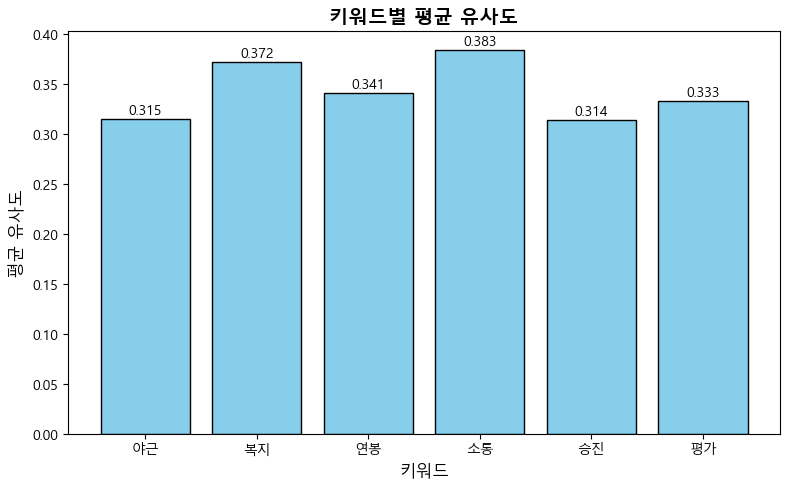

In [38]:
## 평균 유사도 시각화

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (8, 5))
plt.bar(df_score["키워드"], df_score["평균 유사도"], color = 'skyblue', edgecolor = 'black')

plt.title("키워드별 평균 유사도", fontsize = 14, weight = 'bold')
plt.xlabel("키워드", fontsize = 12)
plt.ylabel("평균 유사도", fontsize = 12)

for i, v in enumerate(df_score["평균 유사도"]):
    plt.text(i, v + 0.005, "{:.3f}".format(v), ha = 'center', fontsize = 10)

plt.tight_layout()
plt.show()